## 1. Camera calibration

Goal: find the intrinsic coordinates and distortion coefficients of the camera.

In [113]:
def make_grid(grid_nx, grid_ny, rotation=0):
    grid = np.zeros((grid_nx * grid_ny, 3), dtype=np.float32)
    count = 0
    for y in range(grid_ny):
        for x in range(grid_nx):
            grid[count, 0] = x
            grid[count, 1] = y
            count += 1
            
    if rotation == 1:
        # Rotate 90 degrees counterclockwise (around the center of the grid)
        grid[:, [0, 1]] = grid[:, [1, 0]] 
        grid[:, 0] = grid_ny - 1 - grid[:, 0]

    elif rotation == 2:
        # Rotate 180 degrees
        grid[:, 0] = grid_nx - 1 - grid[:, 0]
        grid[:, 1] = grid_ny - 1 - grid[:, 1]

    elif rotation == 3:
        # Rotate 270 degrees counterclockwise (or 90 degrees clockwise)
        grid[:, [0, 1]] = grid[:, [1, 0]]
        grid[:, 1] = grid_nx - 1 - grid[:, 1]

    return grid

In [115]:
for i in [0, 1, 2, 3]:
    print(make_grid(2, 3, i))

[[0. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 1. 0.]
 [0. 2. 0.]
 [1. 2. 0.]]
[[2. 0. 0.]
 [2. 1. 0.]
 [1. 0. 0.]
 [1. 1. 0.]
 [0. 0. 0.]
 [0. 1. 0.]]
[[1. 2. 0.]
 [0. 2. 0.]
 [1. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 0.]]
[[0. 1. 0.]
 [0. 0. 0.]
 [1. 1. 0.]
 [1. 0. 0.]
 [2. 1. 0.]
 [2. 0. 0.]]


In [112]:
objp

array([[0., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 1., 0.],
       [0., 2., 0.],
       [1., 2., 0.]], dtype=float32)

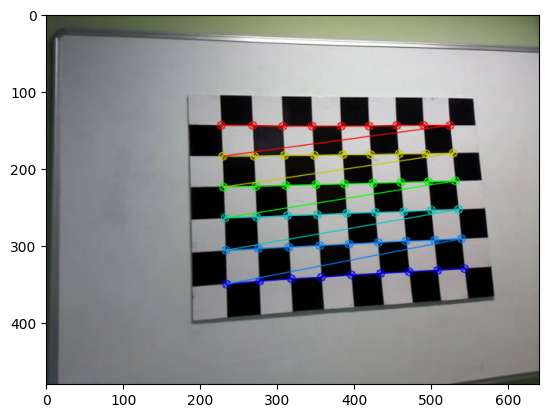

In [124]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import glob

criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

grid_size = (9, 6)
objp = make_grid(grid_size[0], grid_size[1], rotation=0)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('calib_2.jpg')
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, grid_size, None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        # Draw and display the corners
        cv.drawChessboardCorners(img, grid_size, corners2, ret)
        plt.imshow(img)

In [125]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

dist

array([[ 0.14497122, -0.0349204 , -0.00454199, -0.01589941, -0.0887708 ]])

In [122]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print("RETURN:\n", ret)
print("CAMERA_MATRIX:\n", mtx)
print("DISTORTION:\n", dist)
print("ROTATION:\n", rvecs)
print("TRANSLATION:\n", tvecs)

RETURN:
 0.13705150847852227
CAMERA_MATRIX:
 [[462.6225059    0.         257.45163931]
 [  0.         448.28700179 218.70352979]
 [  0.           0.           1.        ]]
DISTORTION:
 [[ 0.14549137 -0.03555369 -0.00453472 -0.01581148 -0.09009423]]
ROTATION:
 (array([[-0.21590648],
       [-0.0493786 ],
       [ 1.53467464]]),)
TRANSLATION:
 (array([[ 7.16254008],
       [-2.03385708],
       [12.61192176]]),)


In [126]:
def display_rotation_vector(rvec):
    angle = np.linalg.norm(rvec)
    direction = rvec / angle
    print(np.abs(angle - np.pi))
    print(f"ANGLE: {angle / np.pi * 180:.2f}")
    print("DIRECTION:\n", direction)
display_rotation_vector(rvecs[0])

0.03031361723410919
ANGLE: 178.26
DIRECTION:
 [[-0.08454725]
 [ 0.05306584]
 [ 0.99500542]]


In [96]:
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
    mean_error += error
print( "total error: {}".format(mean_error/len(objpoints)) )

total error: 0.01865038529229246


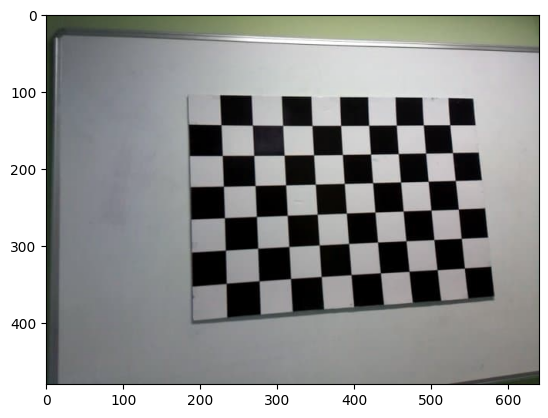

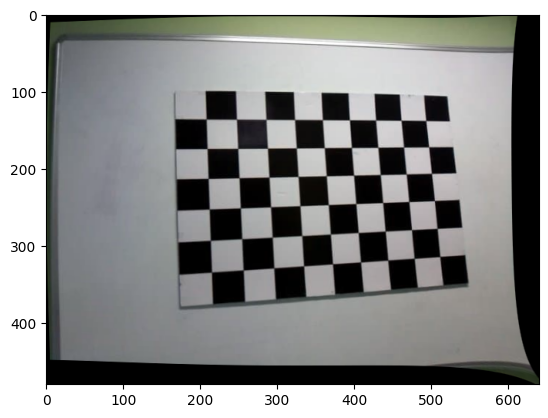

NEW CAMERA MTX:
 [[451.4482557    0.         236.95329258]
 [  0.         436.76740524 208.6841561 ]
 [  0.           0.           1.        ]]
ROI:
 (6, 11, 598, 437)


In [97]:
img = cv.imread('calib_2.jpg')
h,  w = img.shape[:2]

# undistort image
# dist = np.zeros((1, 5))
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
dst = cv.undistort(img, mtx, dist, None, newcameramtx)

# crop the image to the Region of Interest
x, y, w, h = roi
# dst = dst[y:y+h, x:x+w]

plt.imshow(img)
plt.show()
plt.imshow(dst)
plt.show()

print("NEW CAMERA MTX:\n", newcameramtx)
print("ROI:\n", roi)

## 2. Undistort image

## 3. Backproject image

## 4. Warp Perspective transform

https://stackoverflow.com/a/58900781

![](https://i.sstatic.net/BtoDl.png)

```python
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('test.jpg')
rows,cols,ch = img.shape

pts1 = np.float32([[360,50],[2122,470],[2264, 1616],[328,1820]])

ratio=1.6
cardH=math.sqrt((pts1[2][0]-pts1[1][0])*(pts1[2][0]-pts1[1][0])+(pts1[2][1]-pts1[1][1])*(pts1[2][1]-pts1[1][1]))
cardW=ratio*cardH;
pts2 = np.float32([[pts1[0][0],pts1[0][1]], [pts1[0][0]+cardW, pts1[0][1]], [pts1[0][0]+cardW, pts1[0][1]+cardH], [pts1[0][0], pts1[0][1]+cardH]])

M = cv2.getPerspectiveTransform(pts1,pts2)

offsetSize=500
transformed = np.zeros((int(cardW+offsetSize), int(cardH+offsetSize)), dtype=np.uint8);
dst = cv2.warpPerspective(img, M, transformed.shape)

plt.subplot(121),plt.imshow(img),plt.title('Input')
plt.subplot(122),plt.imshow(dst),plt.title('Output')
plt.show()
```

## Rotation vectors

In [77]:
cv.Rodrigues(np.array([np.pi, 0, 0]))[0]

array([[ 1.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00, -1.0000000e+00, -1.2246468e-16],
       [ 0.0000000e+00,  1.2246468e-16, -1.0000000e+00]])

In [100]:
cv.Rodrigues(np.array([np.pi/np.sqrt(2), -np.pi/np.sqrt(2), 0]))[0]

array([[ 2.22044605e-16, -1.00000000e+00, -8.65956056e-17],
       [-1.00000000e+00,  2.22044605e-16, -8.65956056e-17],
       [ 8.65956056e-17,  8.65956056e-17, -1.00000000e+00]])